In [1]:
# Importing Libraries

In [111]:
# Importing Libraries
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.formula.api as smf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
import plotly.express as pe
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

In [110]:
pip install pmdarima

  Using cached pmdarima-2.0.3-cp39-cp39-win_amd64.whl (572 kB)
Note: you may need to restart the kernel to use updated packages.


# Import Dataset

In [5]:
df = pd.read_excel('CocaCola_Sales_Rawdata.xlsx')
df.head(10)

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996
5,Q2_87,2104.411995
6,Q3_87,2014.362999
7,Q4_87,1991.746998
8,Q1_88,1869.049999
9,Q2_88,2313.631996


# EDA

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


In [7]:
df.isnull().sum()

Quarter    0
Sales      0
dtype: int64

In [8]:
df.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


# Feature Engineering

In [9]:
#Converting the Quarters into Years

In [10]:
df['Quarter_Year'] = df['Quarter'].str.split('_').apply(lambda x: ' 19'.join(x[:]))
#Clean way to convert quarterly periods to datetime in pandas
df.head(10)

,Quarter,Sales,Quarter_Year
0,Q1_86,1734.827000,Q1 1986
1,Q2_86,2244.960999,Q2 1986
2,Q3_86,2533.804993,Q3 1986
3,Q4_86,2154.962997,Q4 1986
4,Q1_87,1547.818996,Q1 1987
5,Q2_87,2104.411995,Q2 1987
6,Q3_87,2014.362999,Q3 1987
7,Q4_87,1991.746998,Q4 1987
8,Q1_88,1869.049999,Q1 1988
9,Q2_88,2313.631996,Q2 1988


In [11]:
#Coverting Quarter Years with Quarter Start Date Year (Date Month and Year)

In [12]:
# converting into datetime formate as the index was not in correct formate.
df['Date'] = (
    pd.to_datetime(
        df['Quarter_Year'].str.split(' ').apply(lambda x: ''.join(x[::-1]))
,dayfirst=True))
df.head(10)

,Quarter,Sales,Quarter_Year,Date
0,Q1_86,1734.827000,Q1 1986,1986-01-01
1,Q2_86,2244.960999,Q2 1986,1986-04-01
2,Q3_86,2533.804993,Q3 1986,1986-07-01
3,Q4_86,2154.962997,Q4 1986,1986-10-01
4,Q1_87,1547.818996,Q1 1987,1987-01-01
5,Q2_87,2104.411995,Q2 1987,1987-04-01
6,Q3_87,2014.362999,Q3 1987,1987-07-01
7,Q4_87,1991.746998,Q4 1987,1987-10-01
8,Q1_88,1869.049999,Q1 1988,1988-01-01
9,Q2_88,2313.631996,Q2 1988,1988-04-01


In [13]:
#Extracting the Quarters and putting in column

In [14]:
df['Quarters'] = 0

for i in range(42):
    n = df['Quarter'][i]
    df['Quarters'][i] = n[0:2]
    
df.head(10)

,Quarter,Sales,Quarter_Year,Date,Quarters
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1
5,Q2_87,2104.411995,Q2 1987,1987-04-01,Q2
6,Q3_87,2014.362999,Q3 1987,1987-07-01,Q3
7,Q4_87,1991.746998,Q4 1987,1987-10-01,Q4
8,Q1_88,1869.049999,Q1 1988,1988-01-01,Q1
9,Q2_88,2313.631996,Q2 1988,1988-04-01,Q2


In [15]:
#Creating Dummy Variables for Quarters Variable

In [16]:
dummy = pd.DataFrame(pd.get_dummies(df['Quarters']))
df1 = pd.concat((df, dummy), axis=1)

df1.head()

,Quarter,Sales,Quarter_Year,Date,Quarters,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1,1,0,0,0
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2,0,1,0,0
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3,0,0,1,0
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4,0,0,0,1
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1,1,0,0,0


In [17]:
#Dropping all the unnecessary column

In [18]:
df1.drop(['Quarter','Quarter_Year'] , axis =1, inplace = True)
df1.head()

,Sales,Date,Quarters,Q1,Q2,Q3,Q4
0,1734.827000,1986-01-01,Q1,1,0,0,0
1,2244.960999,1986-04-01,Q2,0,1,0,0
2,2533.804993,1986-07-01,Q3,0,0,1,0
3,2154.962997,1986-10-01,Q4,0,0,0,1
4,1547.818996,1987-01-01,Q1,1,0,0,0


In [19]:
#Making the Date as DateTime index for the Dataframe

In [20]:
df1.set_index('Date',inplace=True)
df1.index.year

Int64Index([1986, 1986, 1986, 1986, 1987, 1987, 1987, 1987, 1988, 1988, 1988,
            1988, 1989, 1989, 1989, 1989, 1990, 1990, 1990, 1990, 1991, 1991,
            1991, 1991, 1992, 1992, 1992, 1992, 1993, 1993, 1993, 1993, 1994,
            1994, 1994, 1994, 1995, 1995, 1995, 1995, 1996, 1996],
           dtype='int64', name='Date')

In [21]:
df1.head()

,Sales,Quarters,Q1,Q2,Q3,Q4
Date,,,,,,
1986-01-01,1734.827000,Q1,1,0,0,0
1986-04-01,2244.960999,Q2,0,1,0,0
1986-07-01,2533.804993,Q3,0,0,1,0
1986-10-01,2154.962997,Q4,0,0,0,1
1987-01-01,1547.818996,Q1,1,0,0,0


In [22]:
#Separating Month and Year into Separate Column for Visualization and removing meaningful insight of the data

In [23]:
df["Date"] = pd.to_datetime(df.Date,format="%b-%y")
df["month"] = df.Date.dt.strftime("%b") # month extraction
df["year"] = df.Date.dt.strftime("%Y") # year extraction
df.head(10)

,Quarter,Sales,Quarter_Year,Date,Quarters,month,year
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1,Jan,1986
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2,Apr,1986
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3,Jul,1986
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4,Oct,1986
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1,Jan,1987
5,Q2_87,2104.411995,Q2 1987,1987-04-01,Q2,Apr,1987
6,Q3_87,2014.362999,Q3 1987,1987-07-01,Q3,Jul,1987
7,Q4_87,1991.746998,Q4 1987,1987-10-01,Q4,Oct,1987
8,Q1_88,1869.049999,Q1 1988,1988-01-01,Q1,Jan,1988
9,Q2_88,2313.631996,Q2 1988,1988-04-01,Q2,Apr,1988


# Data Visualization

<AxesSubplot:xlabel='month', ylabel='year'>

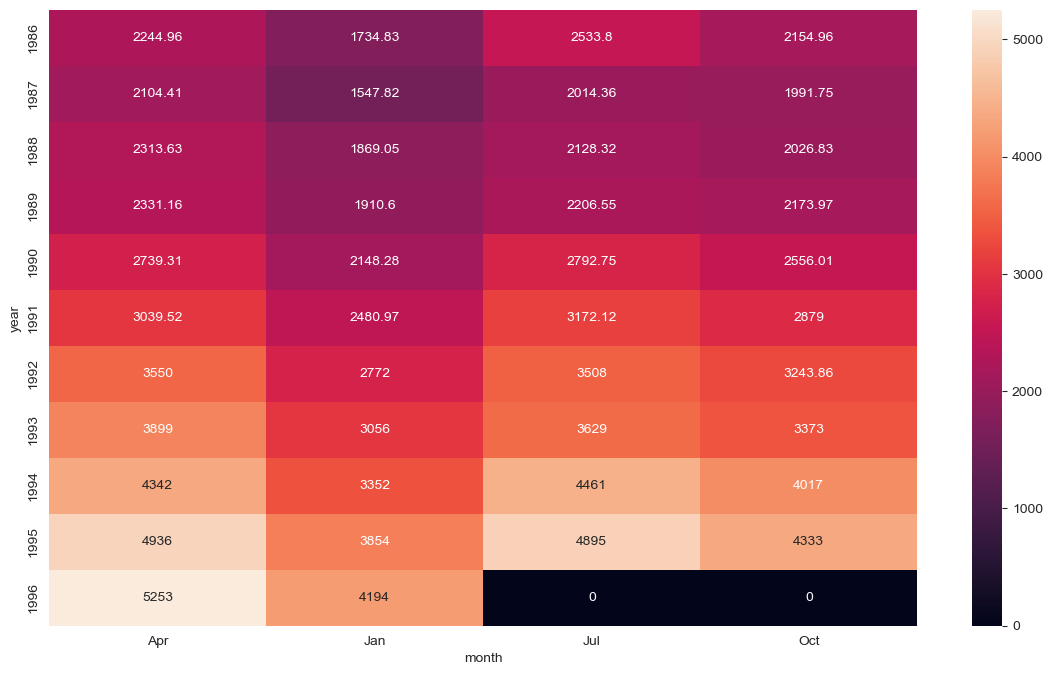

In [25]:
plt.figure(figsize=(14,8))
heatmap_y_month = pd.pivot_table(data=df,values="Sales",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g")

In [26]:
#Line plot

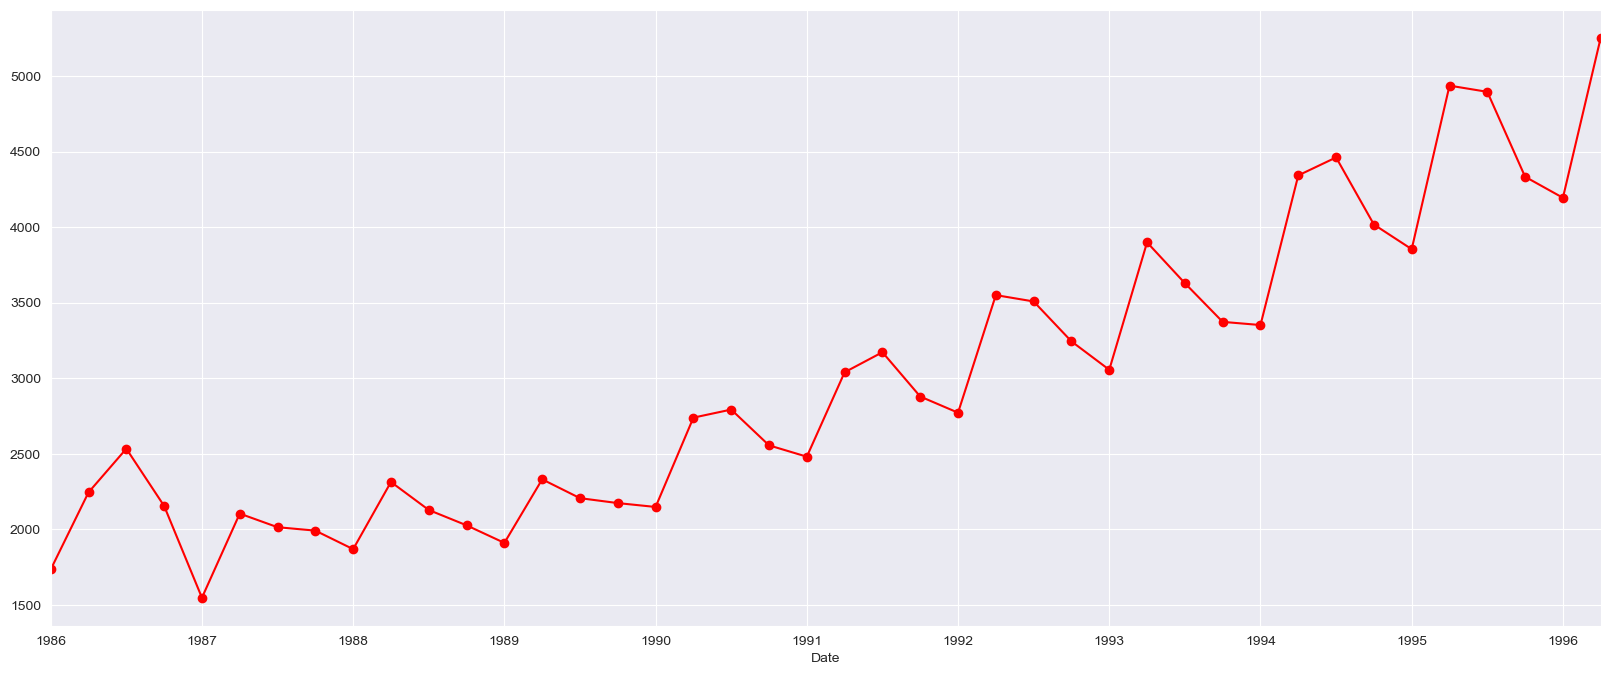

In [27]:
df1['Sales'].plot(figsize=(20, 8),color='red',marker='o')
plt.show()

In [28]:
#Line Plot Using Quarters as Y axis and Sales as X axis

<AxesSubplot:xlabel='Quarters', ylabel='Sales'>

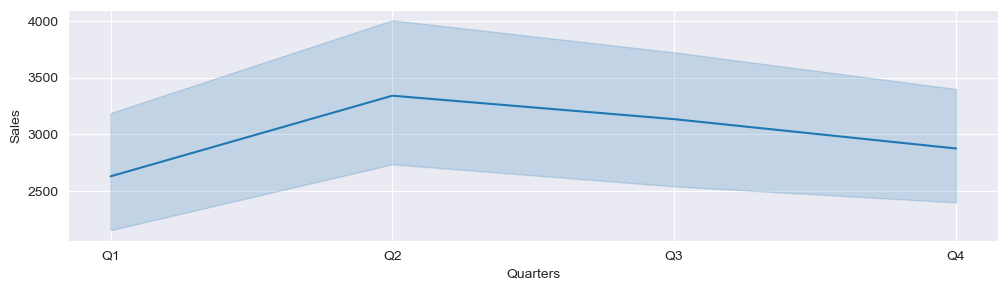

In [29]:
plt.figure(figsize=(12,3))
sns.lineplot(x="Quarters", y="Sales", data=df)

<AxesSubplot:xlabel='year', ylabel='Sales'>

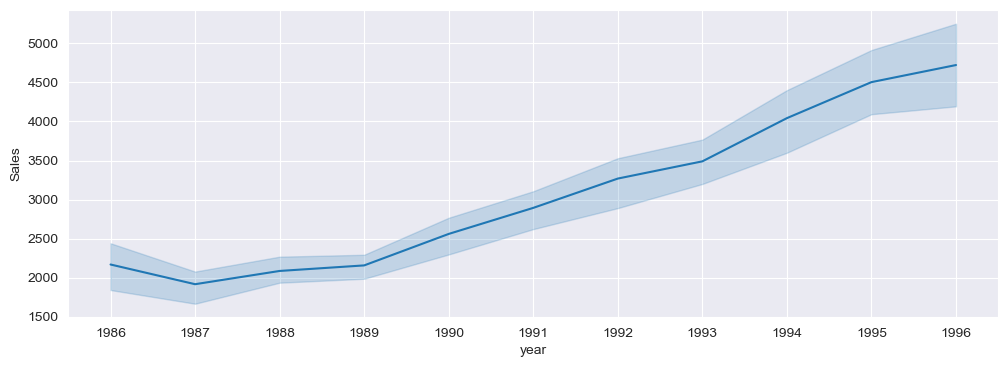

In [30]:
plt.figure(figsize=(12,4))
sns.lineplot(x="year",y="Sales",data=df)

In [32]:
#Box Plot 

<AxesSubplot:xlabel='year', ylabel='Sales'>

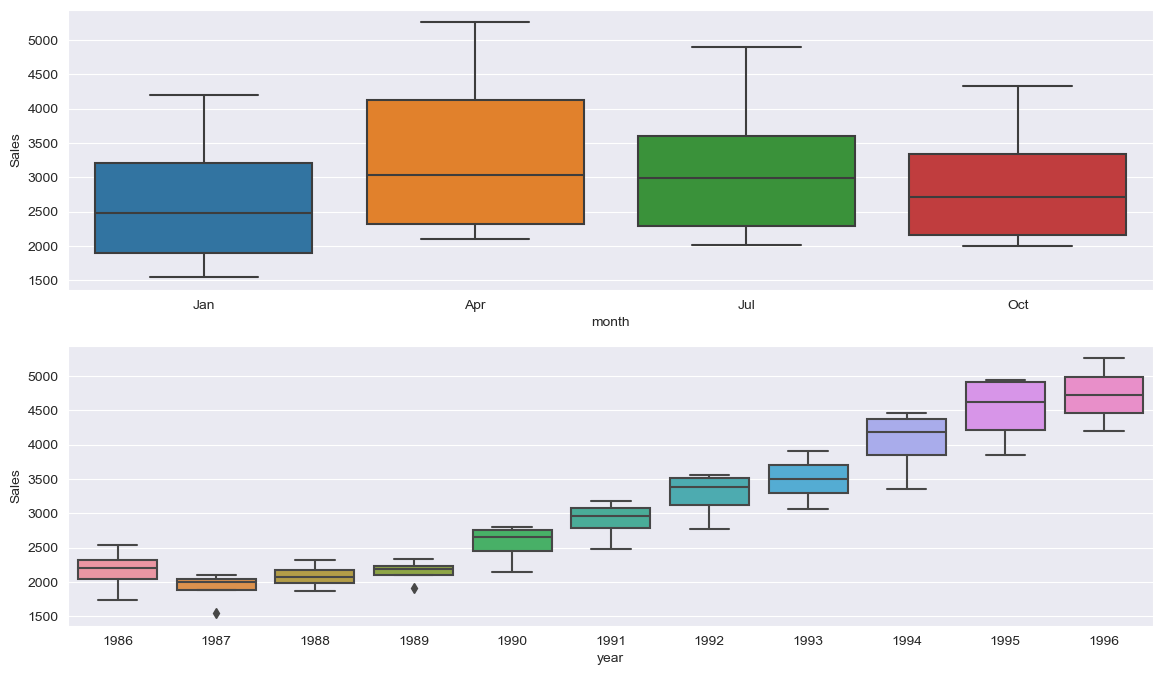

In [33]:
plt.figure(figsize=(14,8))
plt.subplot(211)
sns.boxplot(x="month",y="Sales",data=df)
plt.subplot(212)
sns.boxplot(x="year",y="Sales",data=df)

In [34]:
#Histogram and Density Plots

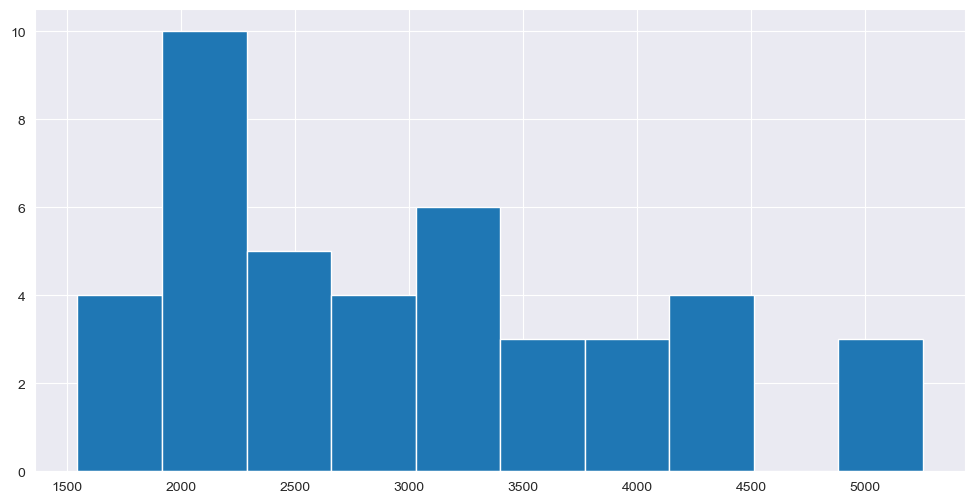

In [36]:
df.Sales.hist(figsize=(12,6))
plt.show()

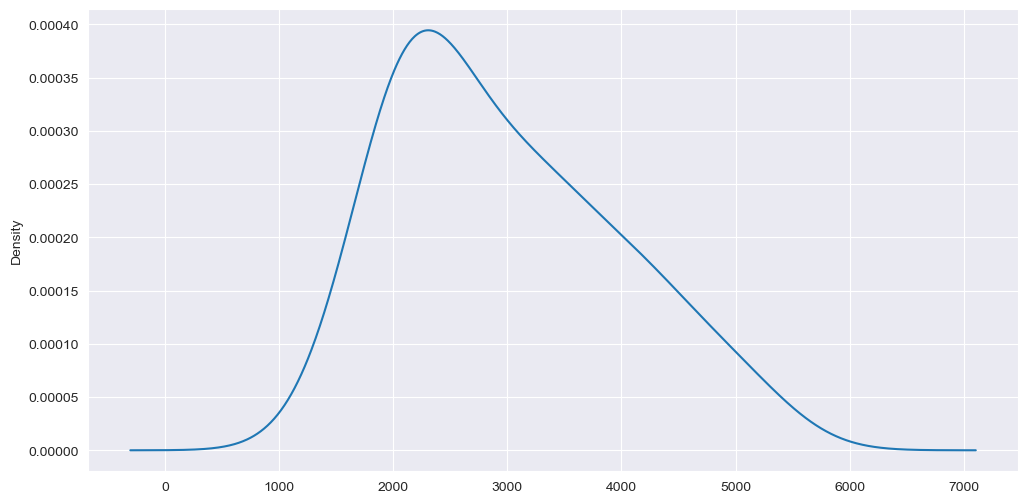

In [37]:
# create a density plot
df.Sales.plot(kind='kde', figsize=(12,6))
plt.show()

In [38]:
#lag plot

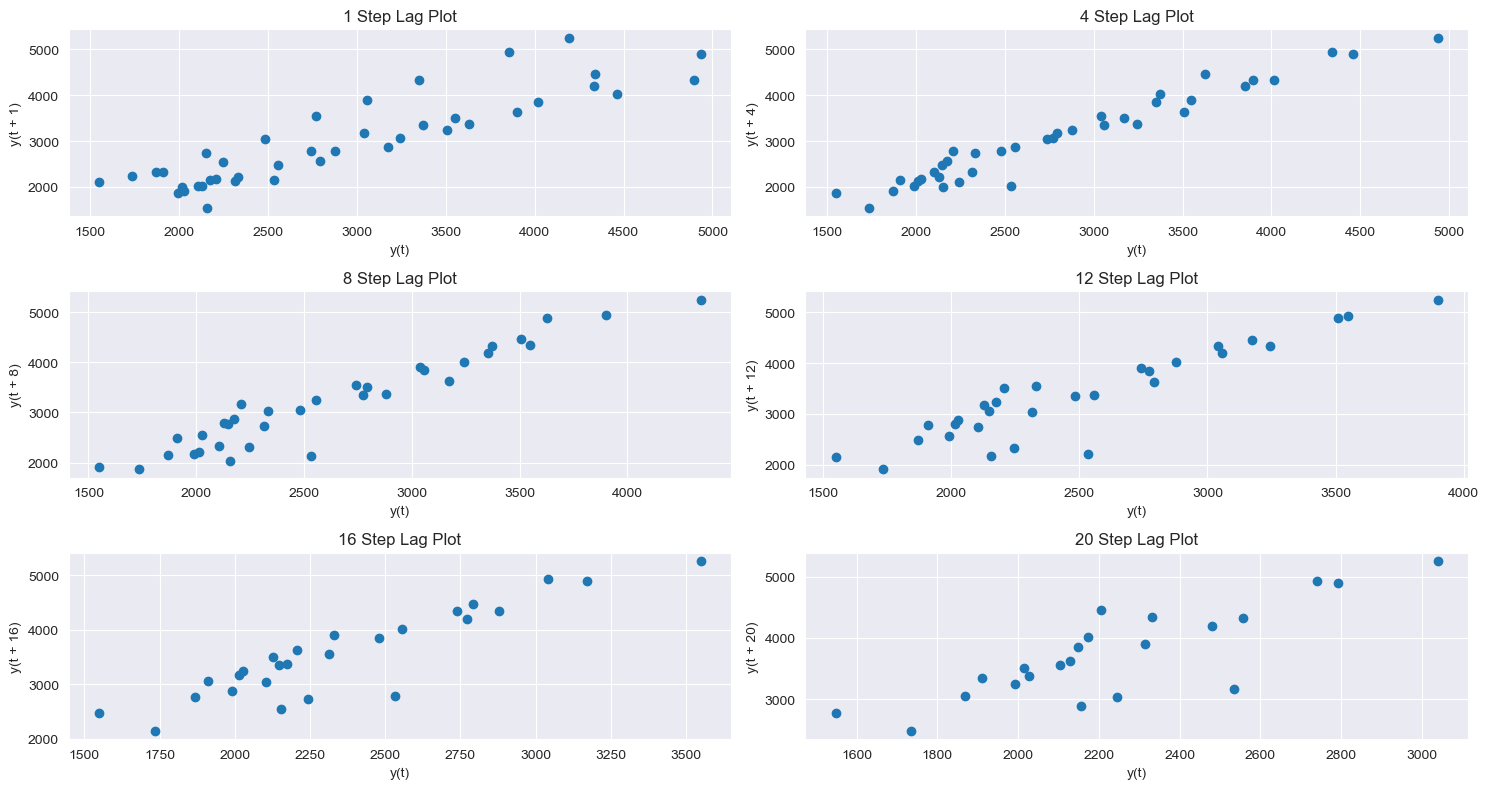

In [40]:
fig, ax = plt.subplots(3, 2, figsize = (15, 8))

plt.setp(ax[0, 0], title ='1 Step Lag Plot')
lag_plot(df.Sales, lag=1, ax = ax[0, 0])

plt.setp(ax[0, 1], title ='4 Step Lag Plot')
lag_plot(df.Sales, lag=4, ax = ax[0, 1])

plt.setp(ax[1, 0], title ='8 Step Lag Plot')
lag_plot(df.Sales, lag=8, ax = ax[1, 0])

plt.setp(ax[1, 1], title ='12 Step Lag Plot')
lag_plot(df.Sales, lag=12, ax = ax[1, 1])

plt.setp(ax[2, 0], title ='16 Step Lag Plot')
lag_plot(df.Sales, lag=16, ax = ax[2, 0])

plt.setp(ax[2, 1], title ='20 Step Lag Plot')
lag_plot(df.Sales, lag=20, ax = ax[2, 1])

plt.tight_layout()

# Moving Average

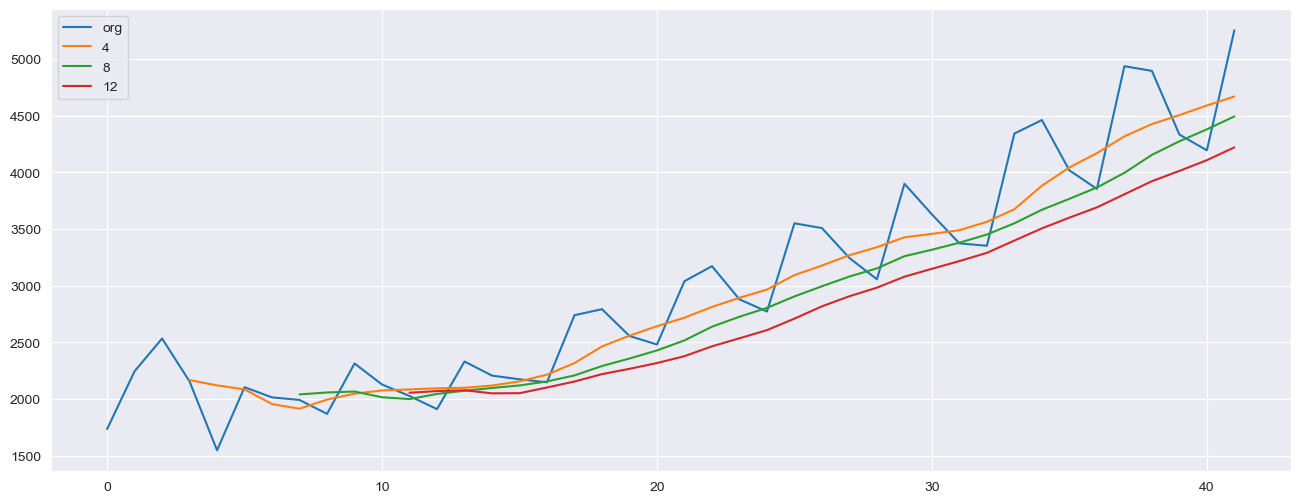

In [41]:
plt.figure(figsize=(16,6))
df.Sales.plot(label="org")
for i in range(4,13,4):
    df["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

# Time series decomposition plot

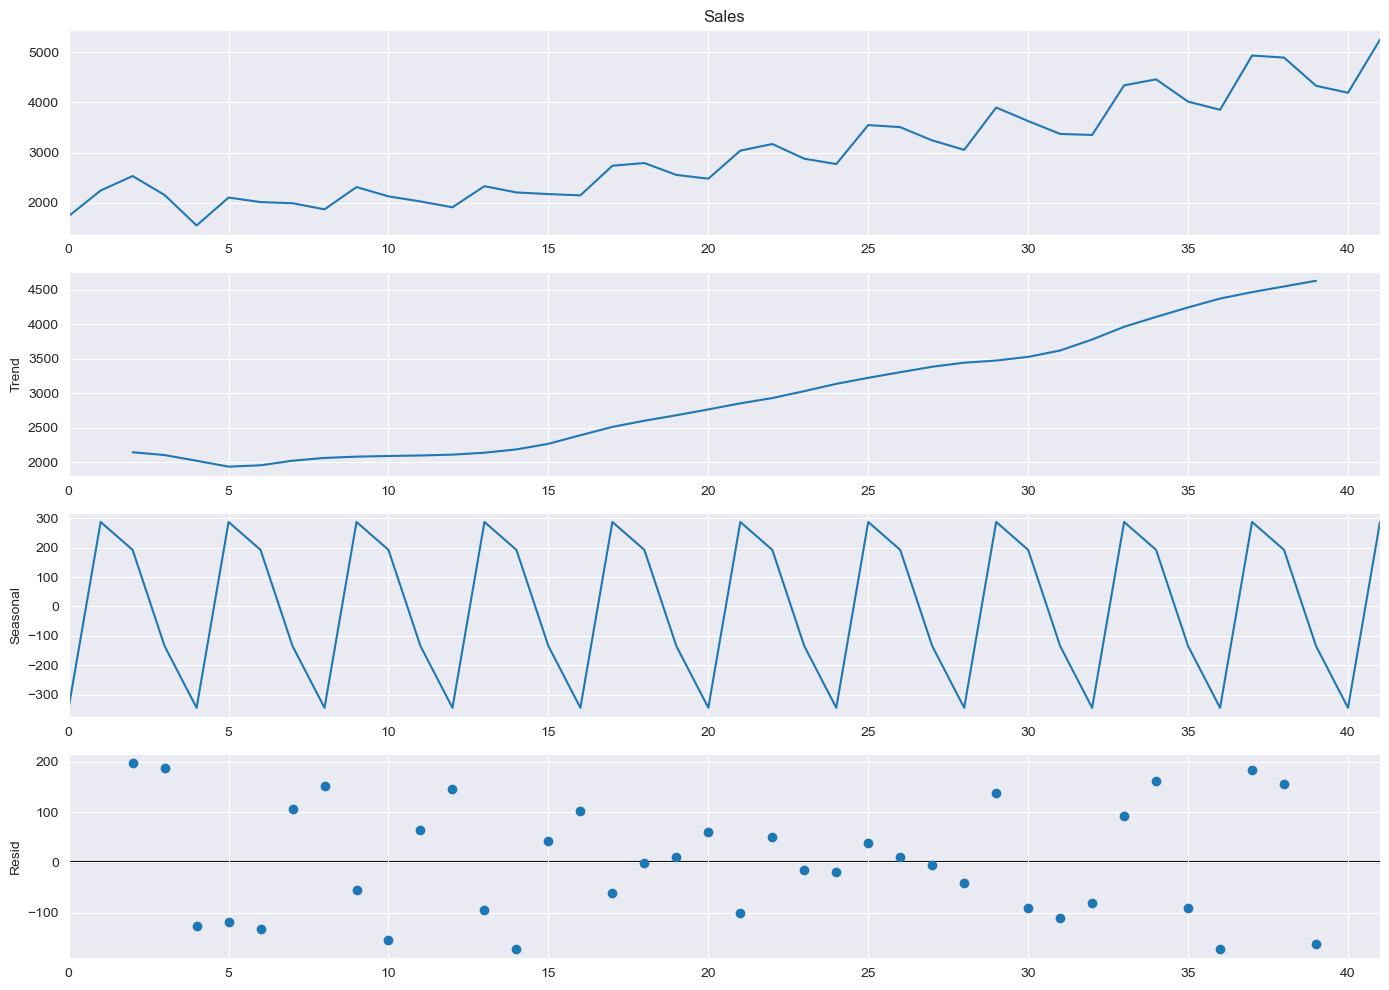

In [42]:
decompose_ts_add = seasonal_decompose(df.Sales,period=4)
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

# ACF plots and PACF plots

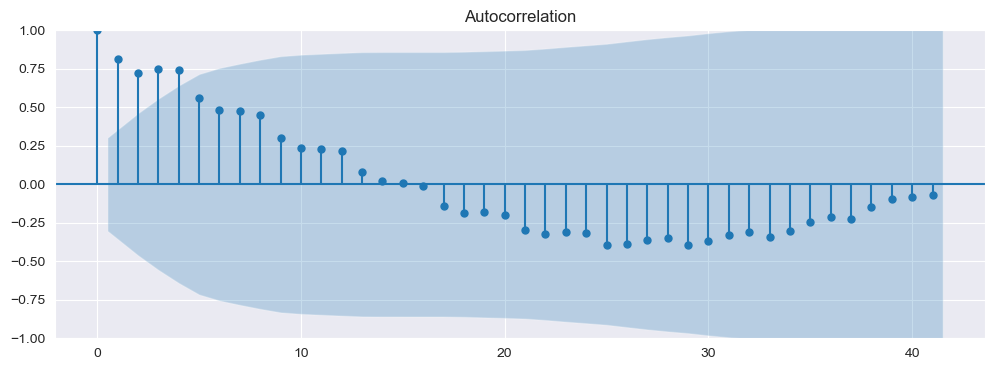

In [43]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(12,4))
    tsa_plots.plot_acf(df.Sales,lags=41)
    plt.show()

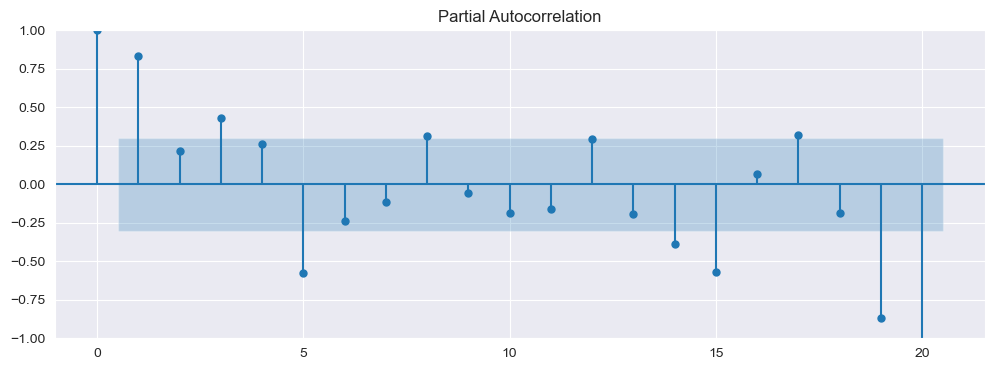

In [44]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(12,4))
    tsa_plots.plot_pacf(df.Sales,lags=20)
    plt.show()

In [45]:
#To summarize, a pacf captures a “direct” correlation between time series and a lagged version of itself.

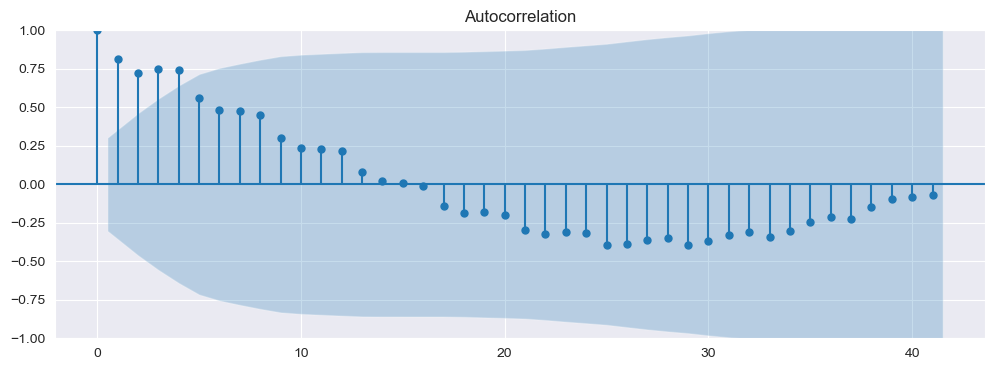

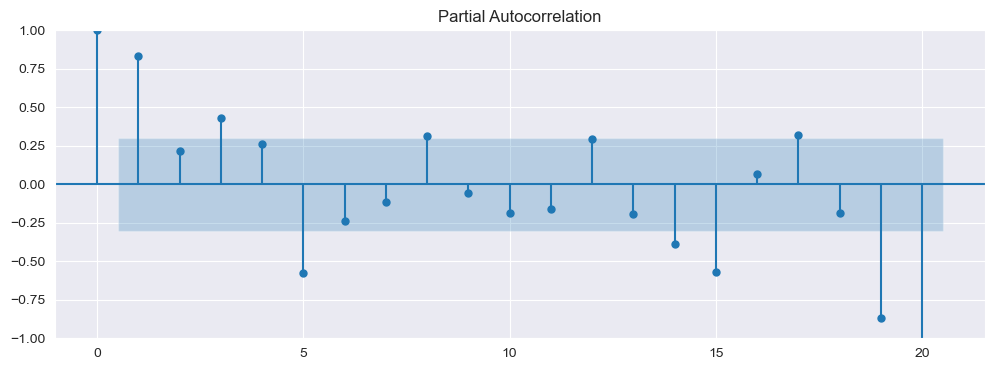

In [46]:
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(12,4))
    tsa_plots.plot_acf(df.Sales,lags=41)
    tsa_plots.plot_pacf(df.Sales,lags=20)
    plt.show()

# Sampling

In [47]:
#Linear interpolation

# upsampling with respect to month

In [48]:
upsampled_month = df1.drop(['Quarters','Q1','Q2','Q3','Q4'], axis=1)
upsampled_month = upsampled_month.resample('M').mean()
print(upsampled_month.head(13))

                  Sales
Date                   
1986-01-31  1734.827000
1986-02-28          NaN
1986-03-31          NaN
1986-04-30  2244.960999
1986-05-31          NaN
1986-06-30          NaN
1986-07-31  2533.804993
1986-08-31          NaN
1986-09-30          NaN
1986-10-31  2154.962997
1986-11-30          NaN
1986-12-31          NaN
1987-01-31  1547.818996


                  Sales
Date                   
1986-01-31  1734.827000
1986-02-28  1904.871666
1986-03-31  2074.916332
1986-04-30  2244.960999
1986-05-31  2341.242330
1986-06-30  2437.523661
1986-07-31  2533.804993
1986-08-31  2407.524328
1986-09-30  2281.243663
1986-10-31  2154.962997
1986-11-30  1952.581664
1986-12-31  1750.200330
1987-01-31  1547.818996
1987-02-28  1733.349996
1987-03-31  1918.880995


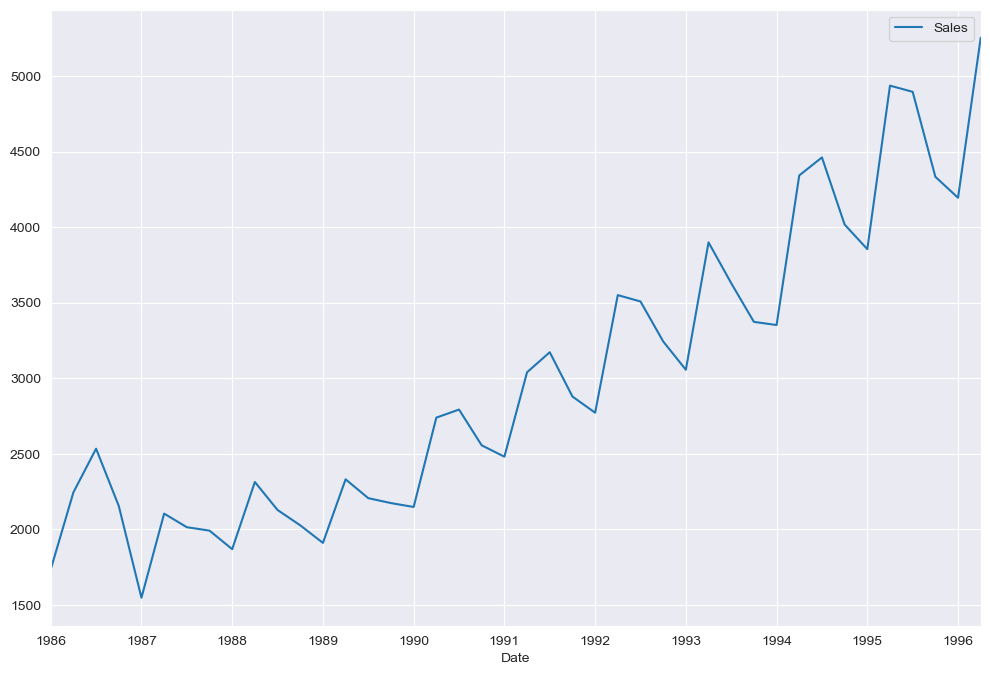

In [121]:
interpolated_month = upsampled_month.interpolate(method='linear') ## interplation was done for nan values which we get after doing upsampling by month
print(interpolated_month.head(15))
interpolated_month.plot(figsize=(12,8))
plt.show()

In [122]:
interpolated_month

,Sales
Date,
1986-01-31,1734.827000
1986-02-28,1904.871666
1986-03-31,2074.916332
1986-04-30,2244.960999
1986-05-31,2341.242330
...,...
1995-12-31,4240.333333
1996-01-31,4194.000000
1996-02-29,4547.000000


# Time Series Decomposition

In [51]:
#Additive Seasonal Decomposition

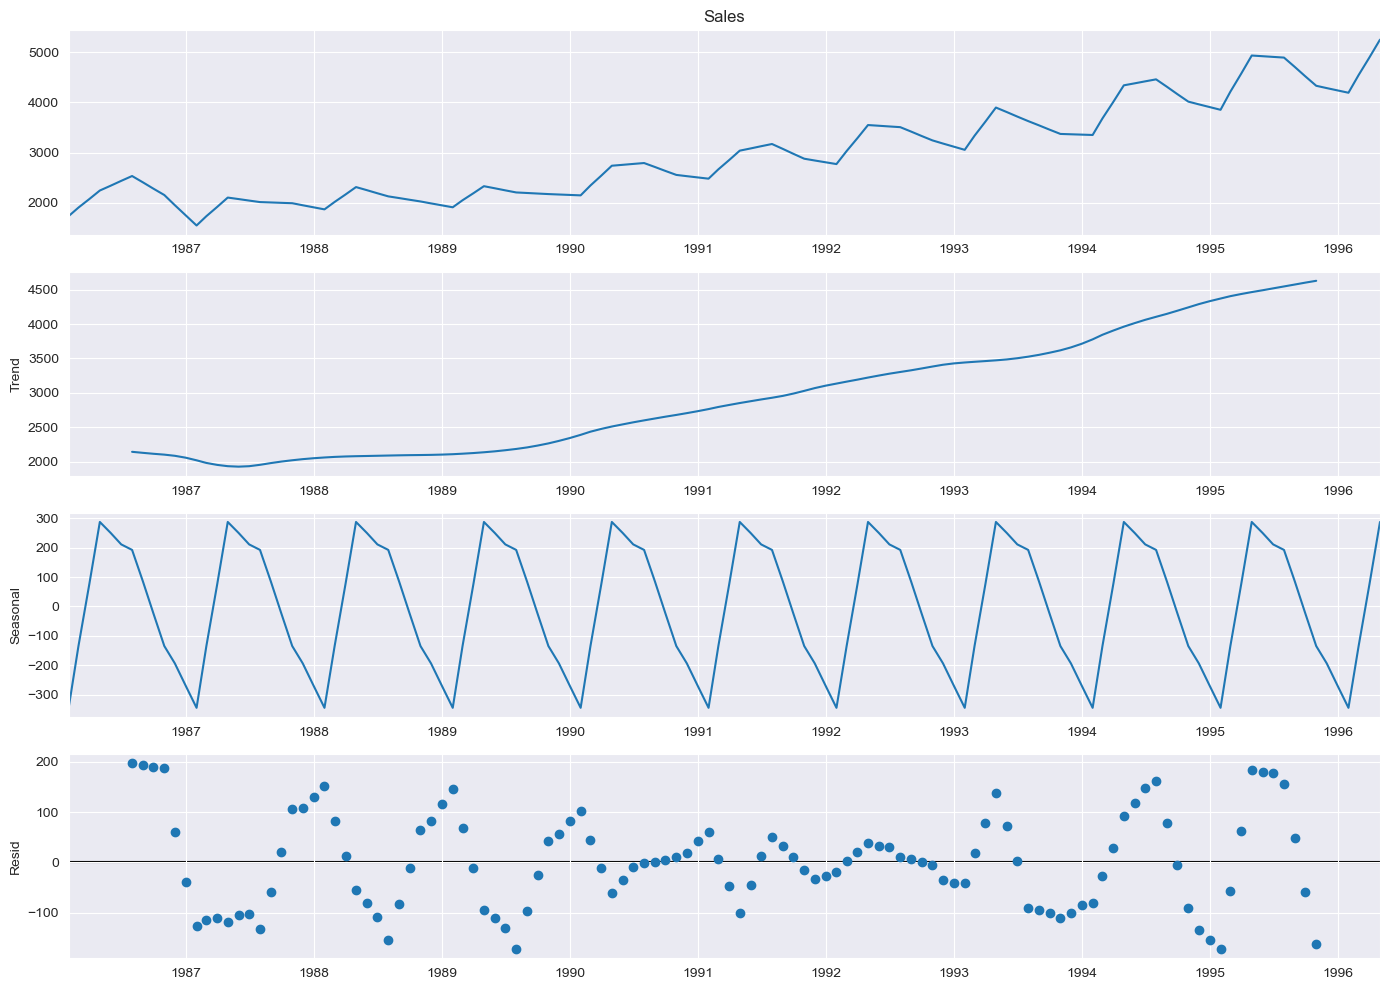

In [52]:
decompose_ts_add = seasonal_decompose(interpolated_month.Sales,period=12, model='additive')
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

In [53]:
#Multiplicative Seasonal Decomposition

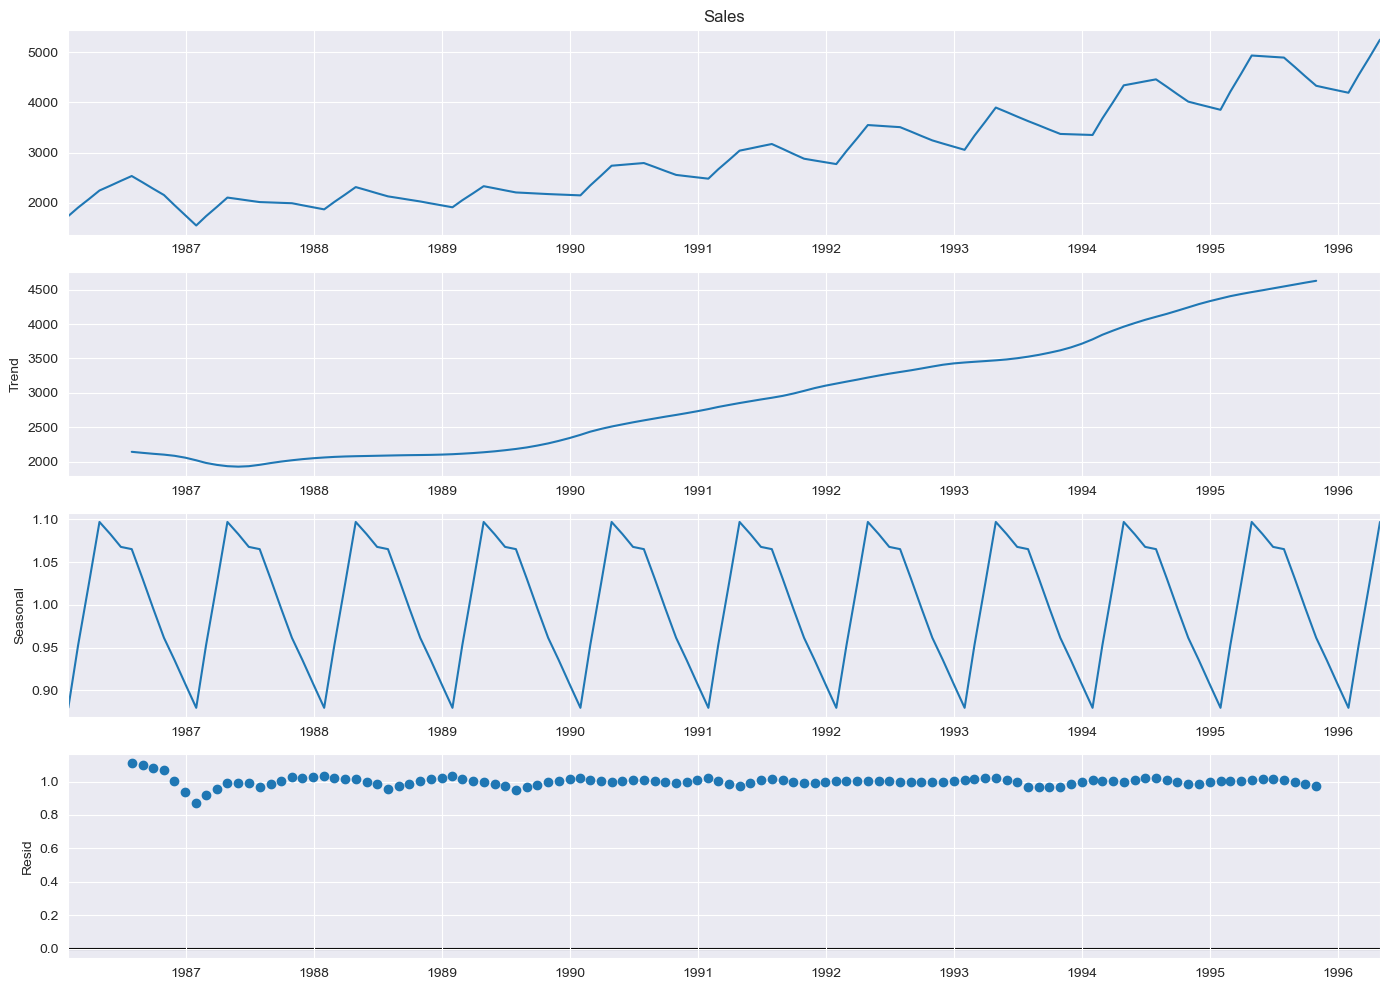

In [59]:
decompose_ts_add = seasonal_decompose(interpolated_month.Sales,period=12, model='multiplicative')
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

# Creating Dummy Variables of the Categorical Feature Month of Date Time feature

In [82]:
interpolated_month.reset_index(inplace=True)
interpolated_month['t'] = np.arange(1,len(interpolated_month)+1)
interpolated_month['t_squared'] = np.square(interpolated_month.t)
interpolated_month["month"] = interpolated_month.Date.dt.strftime("%b") # month extraction
interpolated_month["year"] = interpolated_month.Date.dt.strftime("%Y") # year extraction
months = pd.get_dummies(interpolated_month['month'])
months = months[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]
cocacola = pd.concat([interpolated_month,months],axis=1)
cocacola['log_sales'] = np.log(cocacola['Sales'])
cocacola

,Date,Sales,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_sales
0,1986-01-31,1734.827000,1,1,Jan,1986,1,0,0,0,0,0,0,0,0,0,0,0,7.458663
1,1986-02-28,1904.871666,2,4,Feb,1986,0,1,0,0,0,0,0,0,0,0,0,0,7.552170
2,1986-03-31,2074.916332,3,9,Mar,1986,0,0,1,0,0,0,0,0,0,0,0,0,7.637676
3,1986-04-30,2244.960999,4,16,Apr,1986,0,0,0,1,0,0,0,0,0,0,0,0,7.716443
4,1986-05-31,2341.242330,5,25,May,1986,0,0,0,0,1,0,0,0,0,0,0,0,7.758437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,1995-12-31,4240.333333,120,14400,Dec,1995,0,0,0,0,0,0,0,0,0,0,0,1,8.352397
120,1996-01-31,4194.000000,121,14641,Jan,1996,1,0,0,0,0,0,0,0,0,0,0,0,8.341410
121,1996-02-29,4547.000000,122,14884,Feb,1996,0,1,0,0,0,0,0,0,0,0,0,0,8.422223
122,1996-03-31,4900.000000,123,15129,Mar,1996,0,0,1,0,0,0,0,0,0,0,0,0,8.496990


<AxesSubplot:xlabel='month', ylabel='year'>

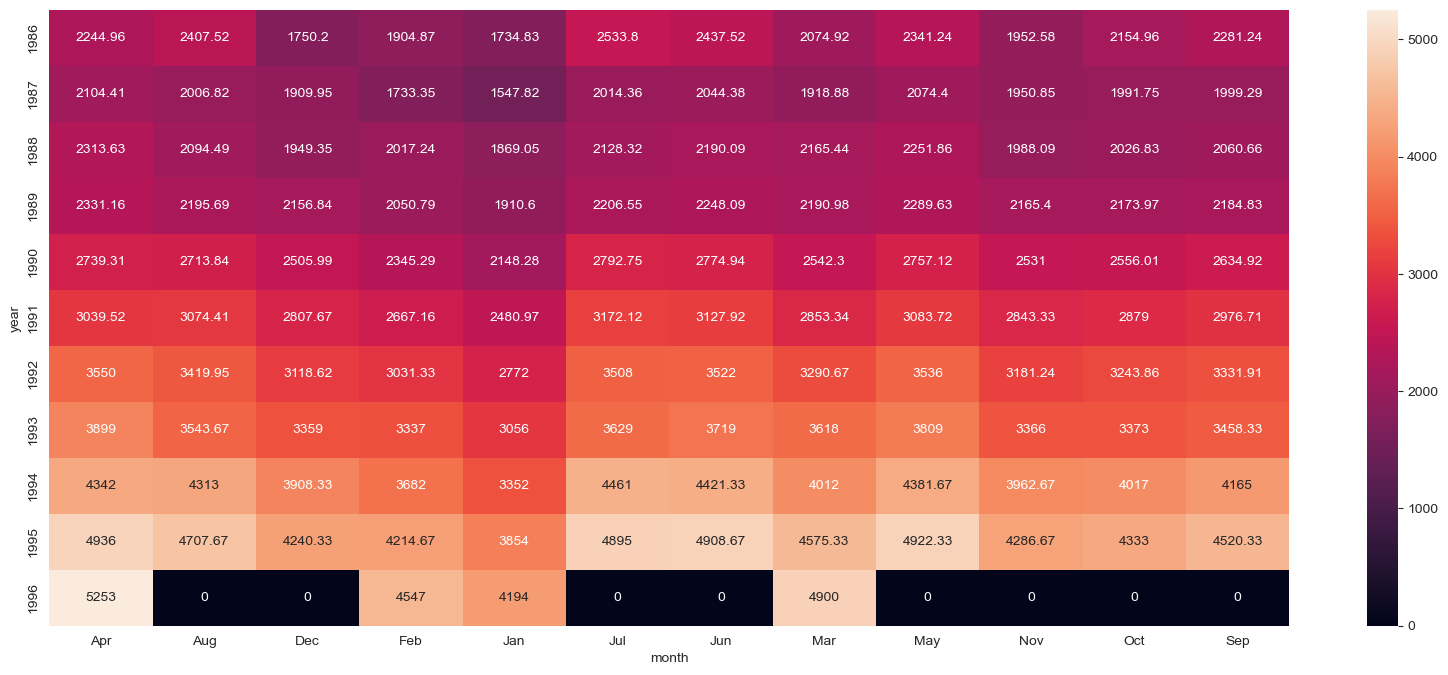

In [83]:
plt.figure(figsize=(20,8))
heatmap_y_month = pd.pivot_table(data=cocacola,values="Sales",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g")

# Splitting Train and Test Data

In [88]:
size = 100

train_data = cocacola.iloc[:size]
test_data = cocacola.iloc[size:]

In [89]:
train_data

,Date,Sales,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_sales
0,1986-01-31,1734.827000,1,1,Jan,1986,1,0,0,0,0,0,0,0,0,0,0,0,7.458663
1,1986-02-28,1904.871666,2,4,Feb,1986,0,1,0,0,0,0,0,0,0,0,0,0,7.552170
2,1986-03-31,2074.916332,3,9,Mar,1986,0,0,1,0,0,0,0,0,0,0,0,0,7.637676
3,1986-04-30,2244.960999,4,16,Apr,1986,0,0,0,1,0,0,0,0,0,0,0,0,7.716443
4,1986-05-31,2341.242330,5,25,May,1986,0,0,0,0,1,0,0,0,0,0,0,0,7.758437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1993-12-31,3359.000000,96,9216,Dec,1993,0,0,0,0,0,0,0,0,0,0,0,1,8.119399
96,1994-01-31,3352.000000,97,9409,Jan,1994,1,0,0,0,0,0,0,0,0,0,0,0,8.117312
97,1994-02-28,3682.000000,98,9604,Feb,1994,0,1,0,0,0,0,0,0,0,0,0,0,8.211211
98,1994-03-31,4012.000000,99,9801,Mar,1994,0,0,1,0,0,0,0,0,0,0,0,0,8.297045


<AxesSubplot:title={'center':'Training VS Testing'}, xlabel='Date', ylabel='Sales'>

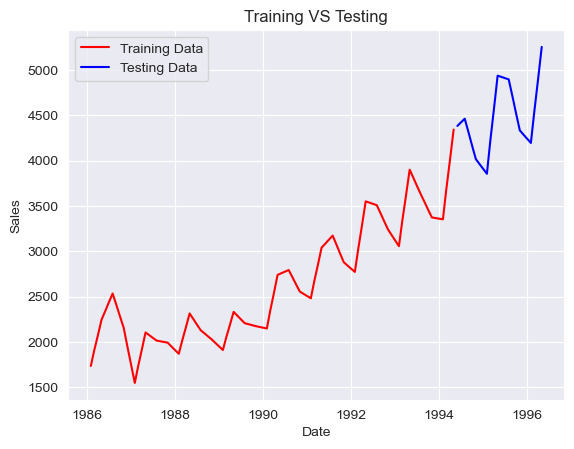

In [90]:
plt.title('Training VS Testing')
sns.lineplot(x=train_data['Date'], y = train_data['Sales'], color = 'red', label = 'Training Data')
sns.lineplot(x=test_data['Date'], y = test_data['Sales'], color = 'blue', label = 'Testing Data')

# Preparing Model

In [91]:
#Creating Linear Model

In [92]:
linear_model = smf.ols('Sales~t',data=train_data).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test_data['t'])))
rmse_linear = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(pred_linear))**2))
rmse_linear

686.8740863668938

In [93]:
#Exponential

Exp = smf.ols('log_sales~t',data=train_data).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(test_data['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

530.3268025099107

In [94]:
#Quadratic 

Quad = smf.ols('Sales~t+t_squared',data=train_data).fit()
pred_Quad = pd.Series(Quad.predict(test_data[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(pred_Quad))**2))
rmse_Quad

371.29418344986567

In [95]:
#Additive seasonality 

add_sea = smf.ols('Sales~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea = pd.Series(add_sea.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]))
rmse_add_sea = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(pred_add_sea))**2))
rmse_add_sea

1837.7879723483788

In [96]:
#Additive Seasonality Quadratic 

add_sea_Quad = smf.ols('Sales~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

225.8049881036863

In [97]:
##Multiplicative Seasonality

Mul_sea = smf.ols('log_sales~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(test_data))
rmse_Mult_sea = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

1904.794417192032

In [98]:
#Multiplicative Additive Seasonality 

Mul_Add_sea = smf.ols('log_sales~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(test_data))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea 

396.4197817382643

In [102]:
#Compare the results 

data = {"Models":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data)


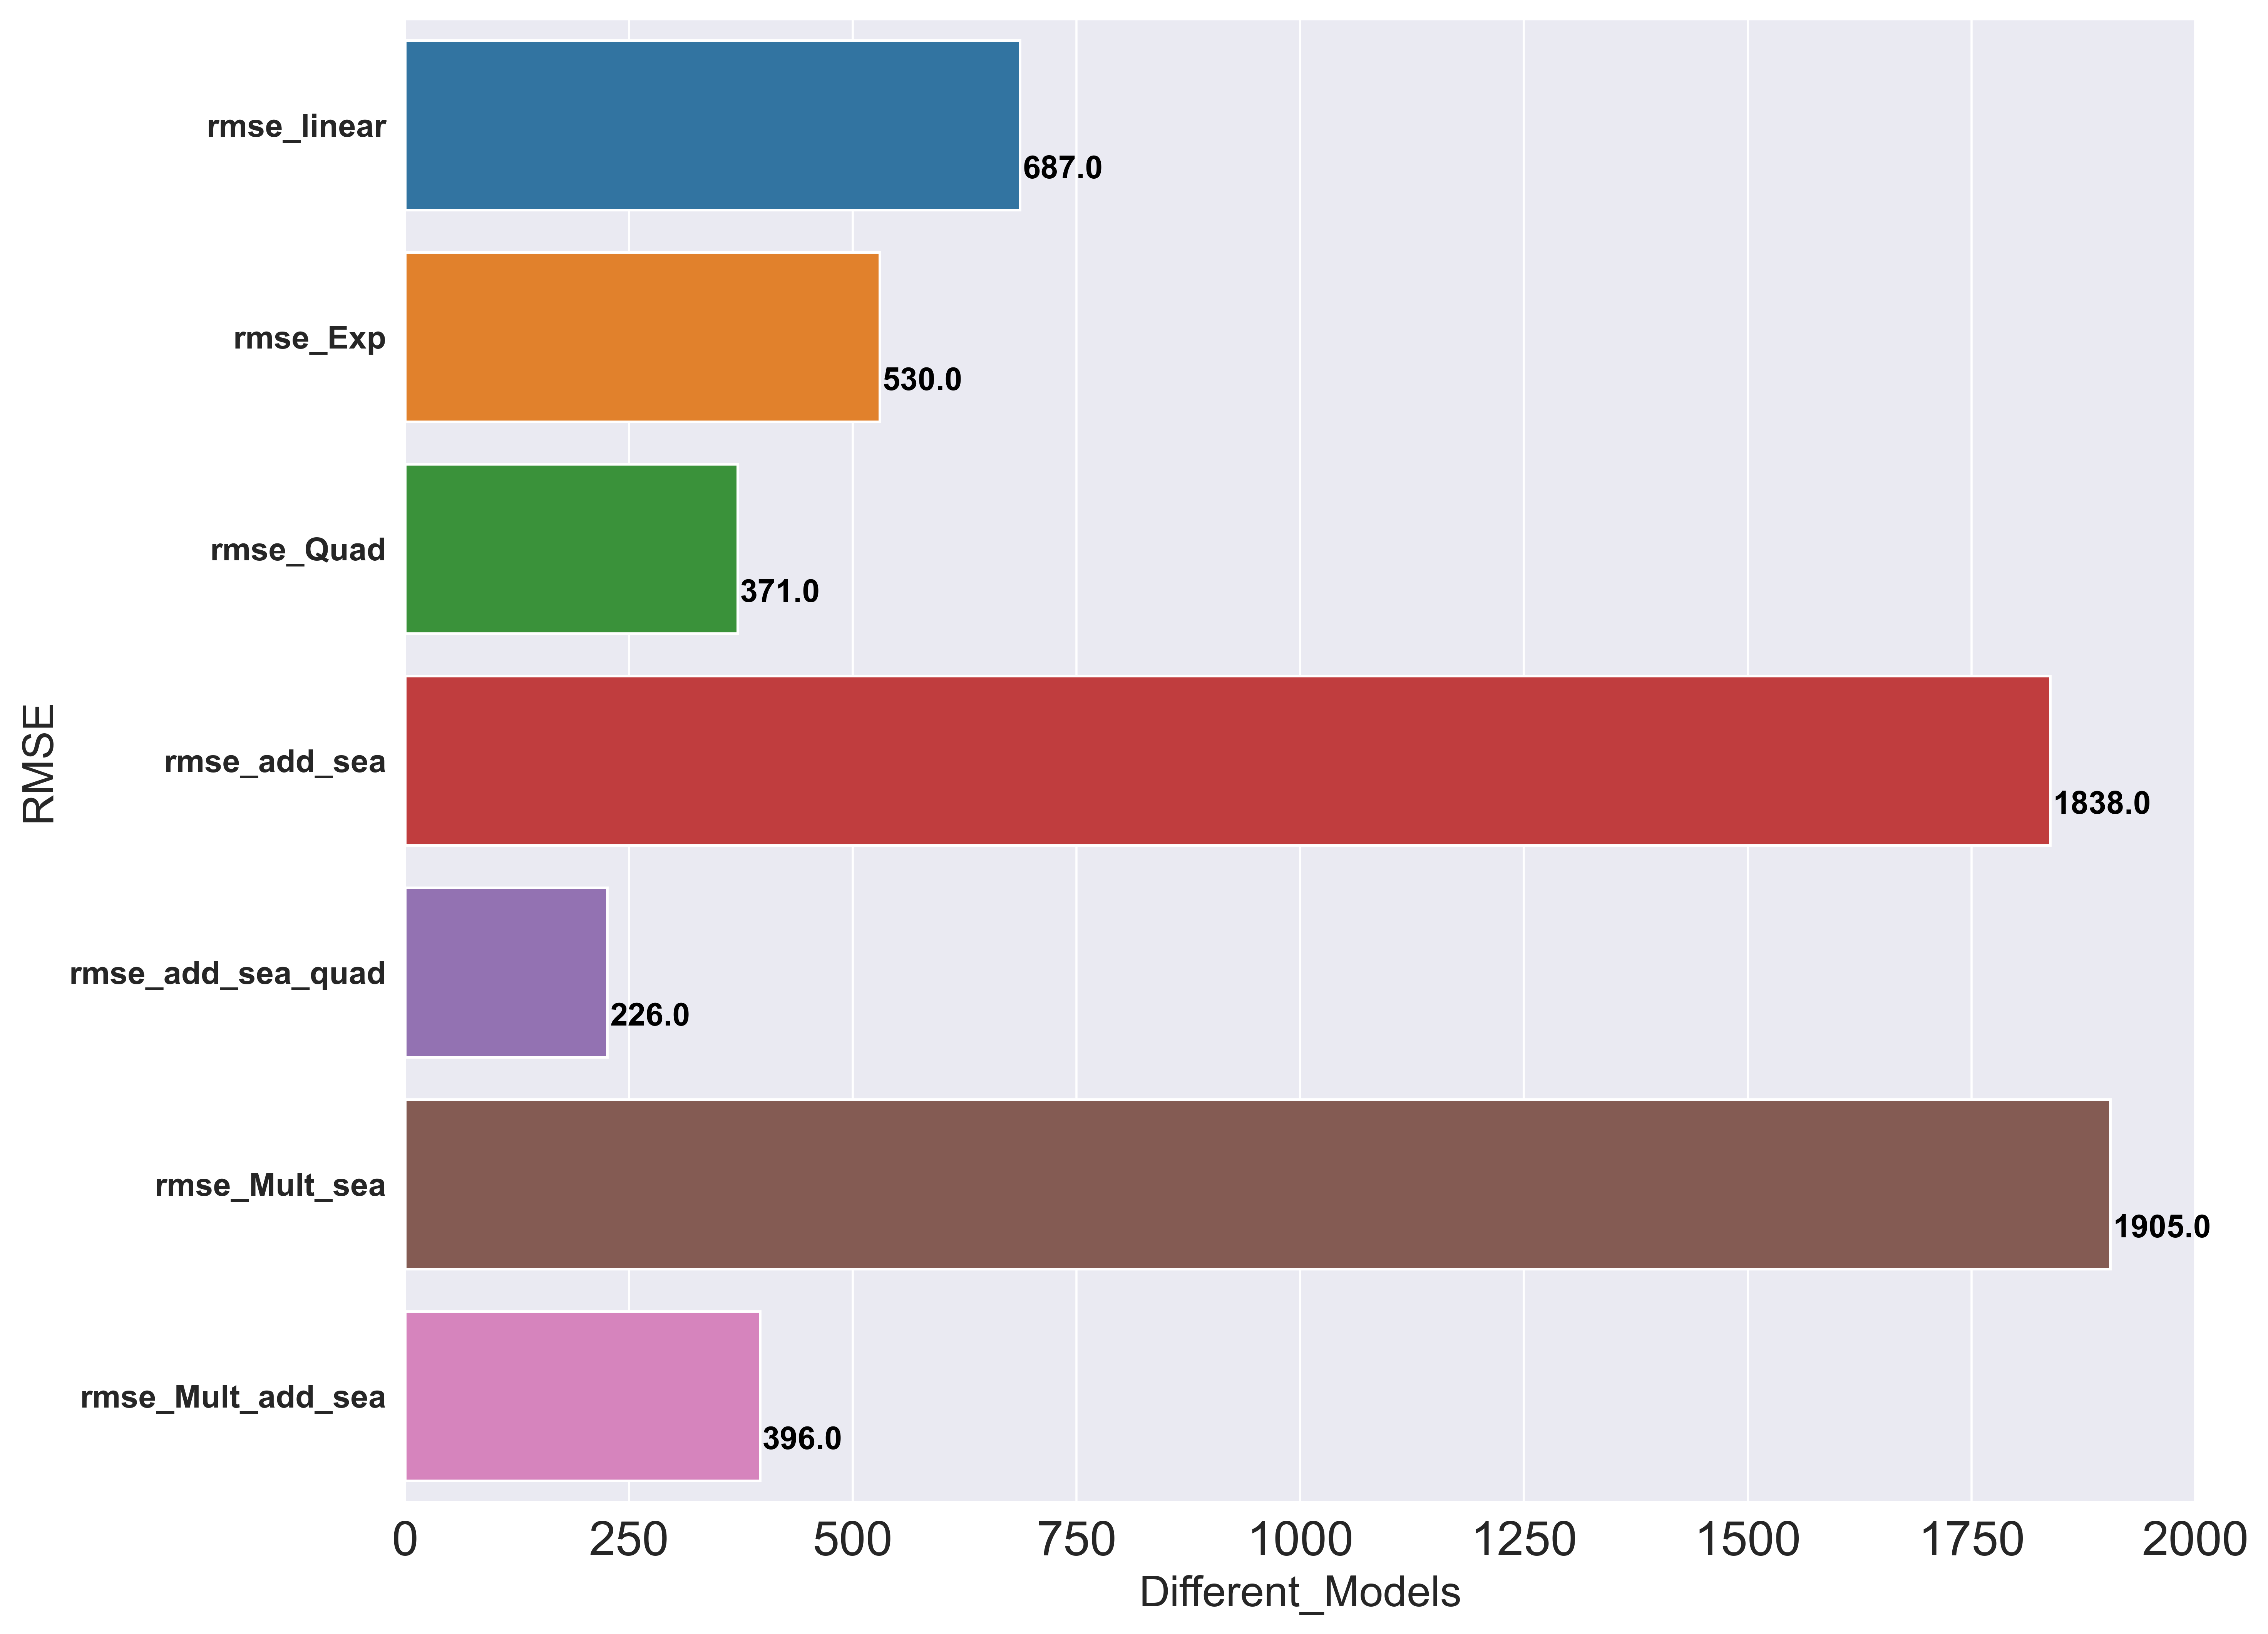

In [106]:
f, axe = plt.subplots(1,1, figsize=(12,10), dpi=500)
sns.barplot(x='RMSE_Values', y='Models', data=table_rmse, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=18)

for i, v in enumerate(np.round(table_rmse.RMSE_Values.values,0)):
    axe.text(v + 3, i + .25, str(v),
            color = 'black', fontweight = 'bold', fontsize= 12)

plt.show()

# Check stationarity of the data

<AxesSubplot:xlabel='Date'>

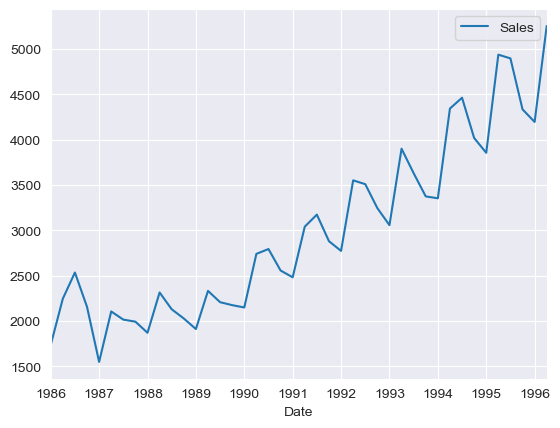

In [123]:
interpolated_month.plot()

In [125]:
adfuller(interpolated_month['Sales'])[1]

0.9869204153832035

# Arima model building

In [124]:
#find out order of arima

In [126]:
order = auto_arima(interpolated_month['Sales'])

In [127]:
order

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True)

In [128]:
interpolated_month.shape

(124, 1)

In [129]:
#Split the data
train = interpolated_month.iloc[:-30]
test = interpolated_month.iloc[-30:]

In [130]:
train.shape

(94, 1)

In [131]:
test.shape

(30, 1)

In [132]:
#Arima model

In [133]:
model = ARIMA(train['Sales'], order=(2, 1, 2)).fit()

# Evaluating the model

In [134]:
test

,Sales
Date,
1993-11-30,3366.000000
1993-12-31,3359.000000
1994-01-31,3352.000000
1994-02-28,3682.000000
1994-03-31,4012.000000
1994-04-30,4342.000000
1994-05-31,4381.666667
1994-06-30,4421.333333
1994-07-31,4461.000000


In [137]:
ypred = model.predict(start =94, end = 123)
ypred

1993-11-30    3384.751018
1993-12-31    3390.592506
1994-01-31    3390.532928
1994-02-28    3390.512156
1994-03-31    3390.512432
1994-04-30    3390.512505
1994-05-31    3390.512504
1994-06-30    3390.512504
1994-07-31    3390.512504
1994-08-31    3390.512504
1994-09-30    3390.512504
1994-10-31    3390.512504
1994-11-30    3390.512504
1994-12-31    3390.512504
1995-01-31    3390.512504
1995-02-28    3390.512504
1995-03-31    3390.512504
1995-04-30    3390.512504
1995-05-31    3390.512504
1995-06-30    3390.512504
1995-07-31    3390.512504
1995-08-31    3390.512504
1995-09-30    3390.512504
1995-10-31    3390.512504
1995-11-30    3390.512504
1995-12-31    3390.512504
1996-01-31    3390.512504
1996-02-29    3390.512504
1996-03-31    3390.512504
1996-04-30    3390.512504
Freq: M, Name: predicted_mean, dtype: float64

In [138]:
print(np.sqrt(mean_squared_error(test['Sales'], ypred)))

1029.0069112845104
